# 练习 - 验证码识别

In [2]:
import os 
import cv2 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import pickle 
import PIL
import matplotlib.pyplot as plt
from PIL import Image 
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [11]:
train_data_dir = './assets/train_data.bin'
val_data_dir = './assets/val_data.bin'
verification_code_dir = './assets/verification_code_data.bin'

In [12]:
def load_file(file_name):
    with open(file_name, mode='rb') as f:
        result = pickle.load(f)
    return result

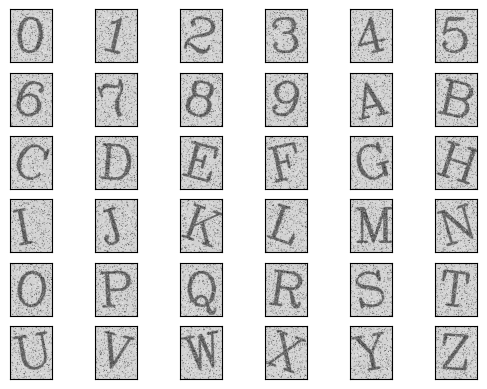

In [13]:
train_data = load_file(train_data_dir)
img_test = list()

for i in range(1, 1800, 50):
    img_test.append(train_data[i][1])

plt.figure()

for i in range(1, 37):
    plt.subplot(6, 6, i)
    plt.imshow(img_test[i-1])
    plt.xticks([])
    plt.yticks([])
plt.show()

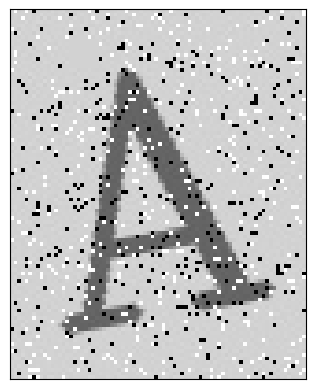

In [14]:
plt.imshow(train_data[500][1])
plt.xticks([])
plt.yticks([])
plt.show()

In [15]:
char_dict = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,\
            'A':10,'B':11,'C':12,'D':13,'E':14,'F':15,'G':16,'H':17,'I':18,'J':19,'K':20,'L':21,'M':22,\
            'N':23,'O':24,'P':25,'Q':26,'R':27,'S':28,'T':29,'U':30,'V':31,'W':32,'X':33,'Y':34,'Z':35}
new_char_dict = {v : k for k, v in char_dict.items()}

In [16]:
class MyDataset(Dataset):
    '''
    需要使用 torch.utils.data.Dataset 作为父类，
    定义自己的 datasets, 以便规范自己的数据集
    '''
    def __init__(self, file_name, transforms):
        self.file_name = file_name # 文件名称
        self.image_label_arr = load_file(self.file_name) # 读入二进制文件
        self.transforms = transforms # 图片转换器
    
    def __getitem__(self, index):
        label, img = self.image_label_arr[index]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # 将图片转位灰度图
        img = cv2.medianBlur(img, 5) # 使用中值模糊出去图片噪音
        img = self.transforms(img) # 对图片进行转换

        return img, char_dict[label[0]]
    
    def __len__(self):
        return len(self.image_label_arr)

In [17]:
# 可以开始定义 transform 和 dataloader 了
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([28, 28]), # 将图片尺寸调整为 28 * 28
                                transforms.ToTensor(), # 将图片转为 tensor
                                transforms.Normalize(mean=[0.5], std=[0.5])]) # 进行归一化处理

train_datasets = MyDataset(train_data_dir, transform)
train_loader = DataLoader(dataset=train_datasets, batch_size=32, shuffle=True)

val_datasets = MyDataset(val_data_dir, transform)
val_loader = DataLoader(dataset=val_datasets, batch_size=32, shuffle=True)

In [19]:
# 定义一个简单的卷积神经网络

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20 * 10 * 10, 500)
        self.fc2 = nn.Linear(500, 36)

    def forward(self, x):
        # inputsize: [b, 1, 28, 28]
        in_size = x.size(0) # b
        out = self.conv1(x) # inputsize:[b, 1, 28, 28] -> outputsize:[b, 10, 24, 24]
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2) # inputsize:[b, 10, 24, 24] -> outputsize:[b, 10, 12, 12]
        out = self.conv2(out) # inputsize:[b, 10, 12, 12] -> outputsize:[b, 20, 10, 10]
        out = F.relu(out)
        out = out.view(in_size, -1) # inputsize:[b, 20, 10, 10] -> outputsize:[b, 2000]
        out = self.fc1(out) # inputsize:[b, 2000] -> outputsize:[b, 500]
        out = F.relu(out)
        out = self.fc2(out) # inputsize:[b, 500] -> outputsize:[b, 36]
        out = F.log_softmax(out, dim = 1)
        return out

In [20]:
# 补全模型训练函数
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [21]:
# 定义模型测试函数
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction = 'sum')
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) \n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [22]:
# 定义模型及优化器
model = ConvNet()
optimizer = optim.Adam(model.parameters())

In [23]:
# 模型训练于测试
EPOCHS = 3
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, val_loader)

Train Epoch: 1 [288/1800 (16%)]	Loss: 3.454732
Train Epoch: 1 [608/1800 (33%)]	Loss: 2.911864
Train Epoch: 1 [928/1800 (51%)]	Loss: 1.960211
Train Epoch: 1 [1248/1800 (68%)]	Loss: 0.972134
Train Epoch: 1 [1568/1800 (86%)]	Loss: 0.420529

Test set: Average loss: 0.3054, Accuracy: 335/360 (93%) 

Train Epoch: 2 [288/1800 (16%)]	Loss: 0.094786
Train Epoch: 2 [608/1800 (33%)]	Loss: 0.120601
Train Epoch: 2 [928/1800 (51%)]	Loss: 0.073640
Train Epoch: 2 [1248/1800 (68%)]	Loss: 0.058856
Train Epoch: 2 [1568/1800 (86%)]	Loss: 0.007260

Test set: Average loss: 0.0139, Accuracy: 359/360 (100%) 

Train Epoch: 3 [288/1800 (16%)]	Loss: 0.002425
Train Epoch: 3 [608/1800 (33%)]	Loss: 0.004629
Train Epoch: 3 [928/1800 (51%)]	Loss: 0.005880
Train Epoch: 3 [1248/1800 (68%)]	Loss: 0.008300
Train Epoch: 3 [1568/1800 (86%)]	Loss: 0.004973

Test set: Average loss: 0.0039, Accuracy: 360/360 (100%) 



In [24]:
# 验证码识别

verification_code_data = load_file(verification_code_dir)

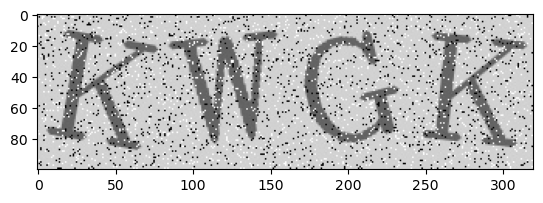

In [30]:
image = verification_code_data[3]
IMG = Image.fromarray(cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB))
plt.imshow(IMG)

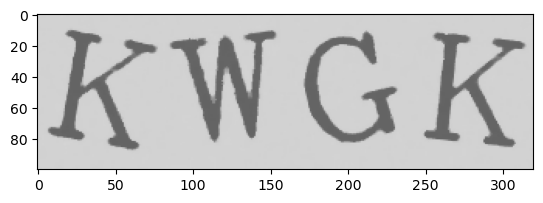

In [31]:
# 中值滤波效果
img = cv2.medianBlur(image.copy(), 5)
plt.imshow(img)

In [28]:
IMAGES = list()
NUMS = list()

for img in verification_code_data:
    IMAGES.append(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    image_1 = img[:, :80]
    image_2 = img[:, 80:160]
    image_3 = img[:, 160:240]
    image_4 = img[:, 240:320]
    img_list = [image_1, image_2, image_3, image_4]

    nums = []
    for one_img in img_list:
        one_img = transform(one_img)
        one_img = one_img.unsqueeze(0)
        output = model(one_img)
        nums.append(new_char_dict[torch.argmax(output).item()])
    NUMS.append('Verification_code: '+''.join(nums))

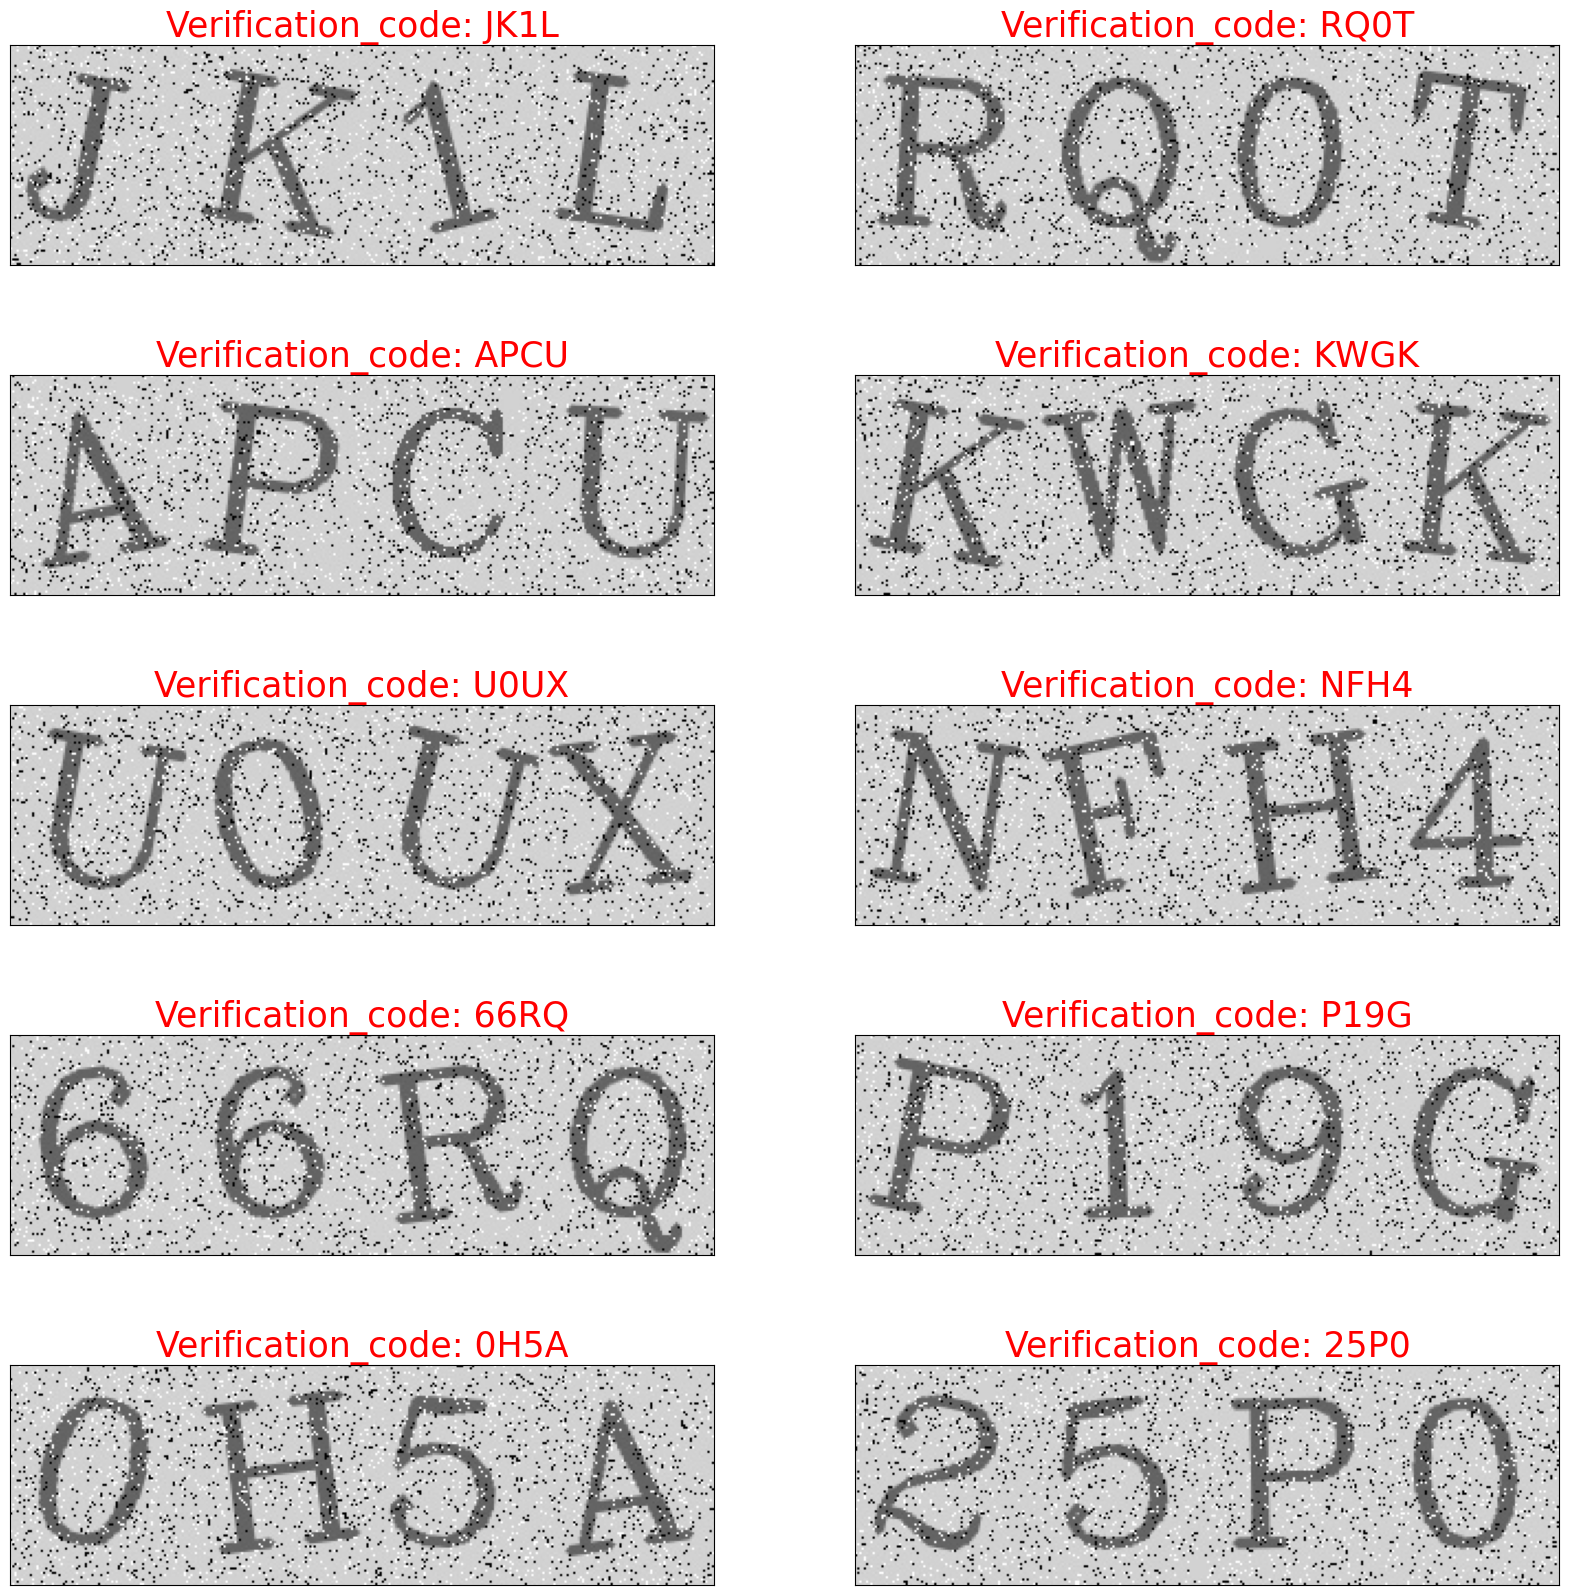

In [29]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for i in range(1, 11):
    plt.subplot(5,2,i)
    plt.title(NUMS[i-1], fontsize=25, color='red')
    plt.imshow(IMAGES[i-1])
    plt.xticks([])
    plt.yticks([])
plt.show()